#  "Fresh Tomato" Predictor: 
# Predicting Movie Success on Rotten Tomatoes

**Author: Ricardo Urdaneta**


The goal of this project is to build a machine learning model to predict if a movie would be a critical success ("Fresh") or failure ("Rotten") on Rotten Tomatoes, based on its metadata.

---
#### Methodology

This notebook follows a complete end-to-end machine learning workflow to predict whether a movie will be rated "Fresh" or "Rotten". The key steps include:

* **Data Loading & Exploratory Data Analysis**: Initial inspection of the dataset, visualization of data distributions, and handling of missing values.

* **Feature Engineering**: Transformation of raw data into machine learning-ready features. This includes creating numerical counts from text fields and using one-hot encoding for categorical variables like content_rating and genres.

* **Baseline Modeling**: Establishing a baseline performance with a simple Logistic Regression model.

* **Iterative Improvement & Advanced Features**: Systematically improving the model by engineering more complex features, such as one-hot encoding the top 30 directors, actors, and production companies.

* **Model Tuning & Selection**: Using `GridSearchCV` and `RandomizedSearchCV` to find the optimal hyperparameters for advanced models like Gradient Boosting and comparing their performance.

* **Final Evaluation**: A final assessment of the best model on a test set to determine its real predictive power.

---
#### Conclusion

The final, champion model, a tuned **Gradient Boosting Classifier**, successfully predicts movie success with **70% accuracy**. The project demonstrated that iterative and intelligent feature engineering, creating granular features for genres, top actors, and directors was the key driver in improving performance beyond the initial baseline.

---

#### Data preparation

In [1]:
# Data manipulation
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings("ignore")

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning - preprocessing and model selection
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MultiLabelBinarizer

# Machine learning - models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# Machine learning - evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Sparse matrix handling
from scipy.sparse import hstack

In [2]:
# Load Data 
filepath = 'data/rotten_tomatoes_movies.csv'
df = pd.read_csv(filepath)

#### Initial inspection

In [3]:
# Show the first few rows of the dataframe
df.head()

,rotten_tomatoes_link,movie_title,movie_info,critics_consensus,content_rating,genres,directors,authors,actors,original_release_date,...,production_company,tomatometer_status,tomatometer_rating,tomatometer_count,audience_status,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count
0,m/0814255,Percy Jackson & the Olympians: The Lightning T...,"Always trouble-prone, the life of teenager Per...",Though it may seem like just another Harry Pot...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,"Craig Titley, Chris Columbus, Rick Riordan","Logan Lerman, Brandon T. Jackson, Alexandra Da...",2010-02-12,...,20th Century Fox,Rotten,49.0,149.0,Spilled,53.0,254421.0,43,73,76
1,m/0878835,Please Give,Kate (Catherine Keener) and her husband Alex (...,Nicole Holofcener's newest might seem slight i...,R,Comedy,Nicole Holofcener,Nicole Holofcener,"Catherine Keener, Amanda Peet, Oliver Platt, R...",2010-04-30,...,Sony Pictures Classics,Certified-Fresh,87.0,142.0,Upright,64.0,11574.0,44,123,19
2,m/10,10,"A successful, middle-aged Hollywood songwriter...",Blake Edwards' bawdy comedy may not score a pe...,R,"Comedy, Romance",Blake Edwards,Blake Edwards,"Dudley Moore, Bo Derek, Julie Andrews, Robert ...",1979-10-05,...,Waner Bros.,Fresh,67.0,24.0,Spilled,53.0,14684.0,2,16,8
3,m/1000013-12_angry_men,12 Angry Men (Twelve Angry Men),Following the closing arguments in a murder tr...,Sidney Lumet's feature debut is a superbly wri...,NR,"Classics, Drama",Sidney Lumet,Reginald Rose,"Martin Balsam, John Fiedler, Lee J. Cobb, E.G....",1957-04-13,...,Criterion Collection,Certified-Fresh,100.0,54.0,Upright,97.0,105386.0,6,54,0
4,m/1000079-20000_leagues_under_the_sea,"20,000 Leagues Under The Sea","In 1866, Professor Pierre M. Aronnax (Paul Luk...","One of Disney's finest live-action adventures,...",G,"Action & Adventure, Drama, Kids & Family",Richard Fleischer,Earl Felton,"James Mason, Kirk Douglas, Paul Lukas, Peter L...",1954-01-01,...,Disney,Fresh,89.0,27.0,Upright,74.0,68918.0,5,24,3


In [4]:
# Summary of data types and non-null counts for each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17712 entries, 0 to 17711
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   rotten_tomatoes_link              17712 non-null  object 
 1   movie_title                       17712 non-null  object 
 2   movie_info                        17391 non-null  object 
 3   critics_consensus                 9134 non-null   object 
 4   content_rating                    17712 non-null  object 
 5   genres                            17693 non-null  object 
 6   directors                         17518 non-null  object 
 7   authors                           16170 non-null  object 
 8   actors                            17360 non-null  object 
 9   original_release_date             16546 non-null  object 
 10  streaming_release_date            17328 non-null  object 
 11  runtime                           17398 non-null  float64
 12  prod

In [5]:
# Count of duplicates in the dataset
df.duplicated().sum()

np.int64(0)

In [6]:
# Count of missing values in each column
df.isnull().sum()

rotten_tomatoes_link                   0
movie_title                            0
movie_info                           321
critics_consensus                   8578
content_rating                         0
genres                                19
directors                            194
authors                             1542
actors                               352
original_release_date               1166
streaming_release_date               384
runtime                              314
production_company                   499
tomatometer_status                    44
tomatometer_rating                    44
tomatometer_count                     44
audience_status                      448
audience_rating                      296
audience_count                       297
tomatometer_top_critics_count          0
tomatometer_fresh_critics_count        0
tomatometer_rotten_critics_count       0
dtype: int64

In [7]:
# Statistical summary for numerical columns
df.describe()

,runtime,tomatometer_rating,tomatometer_count,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count
count,17398.000000,17668.000000,17668.000000,17416.000000,1.741500e+04,17712.000000,17712.000000,17712.000000
mean,102.214048,60.884763,57.139801,60.554260,1.439401e+05,14.586326,36.374831,20.703139
std,18.702511,28.443348,68.370047,20.543369,1.763577e+06,15.146349,52.601038,30.248435
min,5.000000,0.000000,5.000000,0.000000,5.000000e+00,0.000000,0.000000,0.000000
25%,90.000000,38.000000,12.000000,45.000000,7.075000e+02,3.000000,6.000000,3.000000
50%,99.000000,67.000000,28.000000,63.000000,4.277000e+03,8.000000,16.000000,8.000000
75%,111.000000,86.000000,75.000000,78.000000,2.498800e+04,23.000000,44.000000,24.000000
max,266.000000,100.000000,574.000000,100.000000,3.579764e+07,69.000000,497.000000,303.000000


In [8]:
# Stadistical summary for categorical columns
df.describe(include='object')

,rotten_tomatoes_link,movie_title,movie_info,critics_consensus,content_rating,genres,directors,authors,actors,original_release_date,streaming_release_date,production_company,tomatometer_status,audience_status
count,17712,17712,17391,9134,17712,17693,17518,16170,17360,16546,17328,17213,17668,17264
unique,17712,17106,17389,9132,6,1106,8933,12989,17330,5804,2271,3046,3,2
top,m/zombeavers,Hamlet,"Wisecracking mercenary Deadpool meets Russell,...","Extinction has a few intriguing ideas, but the...",R,Drama,Clint Eastwood,Woody Allen,Werner Herzog,2002-01-01,2016-08-10,Paramount Pictures,Rotten,Upright
freq,1,6,2,2,6377,1887,38,33,4,29,1235,517,7565,9390


#### Target variable

In [9]:
# Create the Target Variable (y): Our goal is to predict if a movie is 'Fresh' (1) or 'Rotten' (0).
print(f"Original shape: {df.shape}")
print(f"Missing values in 'tomatometer_status' before cleaning: {df['tomatometer_status'].isnull().sum()}")

Original shape: (17712, 22)
Missing values in 'tomatometer_status' before cleaning: 44


In [10]:
# Drop rows where the target is missing
df.dropna(subset=['tomatometer_status'], inplace=True)

print(f"\nShape after dropping rows with no status: {df.shape}")


Shape after dropping rows with no status: (17668, 22)


In [11]:
# Create the binary 'is_fresh' column: 'Rotten' to 0 and both 'Fresh' and 'Certified-Fresh' to 1.
df['is_fresh'] = np.where(df['tomatometer_status'] == 'Rotten', 0, 1)

# Check results
print("\nValue counts for our new target variable 'is_fresh':")
print(df['is_fresh'].value_counts())


Value counts for our new target variable 'is_fresh':
is_fresh
1    10103
0     7565
Name: count, dtype: int64


#### Class balance


--- Visualizing Class Balance ---


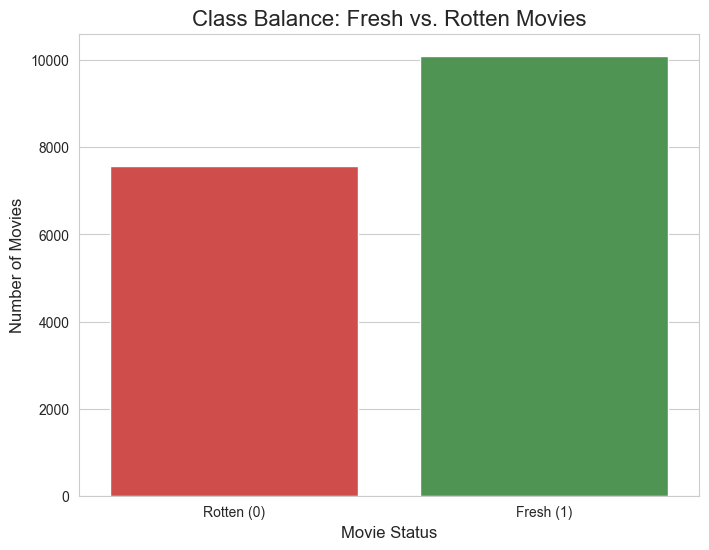

In [12]:
# Visualize the class balance
print("\n--- Visualizing Class Balance ---")
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid") # Optional: for a nicer plot style

# Create the count plot
ax = sns.countplot(x='is_fresh', data=df, palette=['#E53935', '#43A047'])

# Title and labels
plt.title('Class Balance: Fresh vs. Rotten Movies', fontsize=16)
plt.ylabel('Number of Movies', fontsize=12)
plt.xlabel('Movie Status', fontsize=12)

# Customize x-axis labels
ax.set_xticklabels(['Rotten (0)', 'Fresh (1)'])

# Show the plot
plt.show()


#### Feature Engineering

We will extract key movie attributes, create count-based features, select relevant predictors and handle missing values for model training.

In [13]:
# Extract Release Year from 'movie_info': this creates a new 'release_year' column.
df['release_year'] = df['movie_info'].str.extract(r'(\d{4})').astype(float)

# Create Counts from -List- Columns
df['num_genres'] = df['genres'].str.split(',').str.len().fillna(0)
df['num_directors'] = df['directors'].str.split(',').str.len().fillna(0)
df['num_actors'] = df['actors'].str.split(',').str.len().fillna(0)

# Select the Final Feature Set (X)
features_to_use = [
    'content_rating',  
    'runtime',         
    'release_year',    
    'num_genres',      
    'num_directors',   
    'num_actors'       
]

# Create the feature matrix X and the target vector y
X = df[features_to_use].copy()  
y = df['is_fresh']

# Handle remaining missing values in X
print("--- Handling Missing Values in Features ---")
print("Missing values BEFORE cleaning:")
print(X.isnull().sum())

# For numerical columns, filling with the median is a robust strategy
for col in ['runtime', 'release_year']:
    median_val = X[col].median()
    X[col].fillna(median_val, inplace=True)

# For the categorical 'content_rating', fill with a placeholder string
X['content_rating'].fillna('Not Rated', inplace=True)

print("\nMissing values AFTER cleaning:")
print(X.isnull().sum())

# Final check 
print("\n--- Feature Engineering Complete ---")
print("\nFirst 5 rows of our final features (X):")
print(X.head())

--- Handling Missing Values in Features ---
Missing values BEFORE cleaning:
content_rating        0
runtime             284
release_year      16176
num_genres            0
num_directors         0
num_actors            0
dtype: int64

Missing values AFTER cleaning:
content_rating    0
runtime           0
release_year      0
num_genres        0
num_directors     0
num_actors        0
dtype: int64

--- Feature Engineering Complete ---

First 5 rows of our final features (X):
  content_rating  runtime  release_year  num_genres  num_directors  num_actors
0             PG    119.0        1964.0         4.0            1.0        87.0
1              R     90.0        1964.0         1.0            1.0         8.0
2              R    122.0        1964.0         2.0            1.0        46.0
3             NR     95.0        1964.0         2.0            1.0        16.0
4              G    127.0        1866.0         3.0            1.0        16.0


#### One-Hot Encoding

We'll use the `pd.get_dummies()` function. It will take the `content_rating` column and create new, separate columns for each rating category like 'R', 'PG-13', etc.

For any given movie, the column corresponding to its rating will have a 1, and all other new rating columns will have a 0.

In [14]:
# Apply One-Hot Encoding 
print("Shape of X before One-Hot Encoding:", X.shape)
print("Columns in X:", X.columns)

# Use pd.get_dummies to convert the 'content_rating' column
X_encoded = pd.get_dummies(X, columns=['content_rating'], drop_first=True)


# Final Check 
print("\nShape of X after One-Hot Encoding:", X_encoded.shape)
print("First 5 rows of our fully prepared feature set (X_encoded):")
print(X_encoded.head())

Shape of X before One-Hot Encoding: (17668, 6)
Columns in X: Index(['content_rating', 'runtime', 'release_year', 'num_genres',
       'num_directors', 'num_actors'],
      dtype='object')

Shape of X after One-Hot Encoding: (17668, 10)
First 5 rows of our fully prepared feature set (X_encoded):
   runtime  release_year  num_genres  num_directors  num_actors  \
0    119.0        1964.0         4.0            1.0        87.0   
1     90.0        1964.0         1.0            1.0         8.0   
2    122.0        1964.0         2.0            1.0        46.0   
3     95.0        1964.0         2.0            1.0        16.0   
4    127.0        1866.0         3.0            1.0        16.0   

   content_rating_NC17  content_rating_NR  content_rating_PG  \
0                False              False               True   
1                False              False              False   
2                False              False              False   
3                False               True    

#### Correlation Heatmap

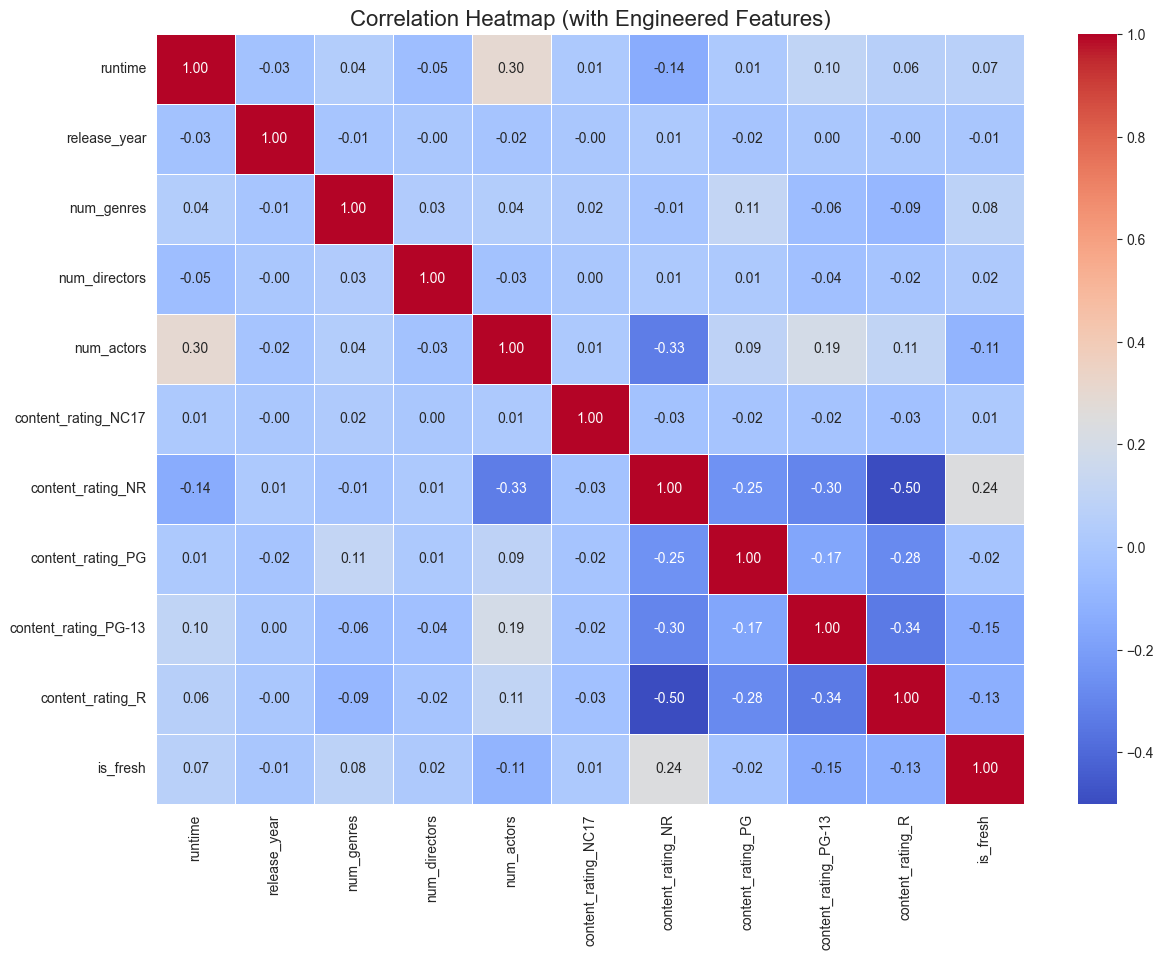

In [15]:
# Combine final features
combined_df = pd.concat([X_encoded, y], axis=1)

# Calculate the correlation matrix on this complete DataFrame
final_correlation_matrix = combined_df.corr()

# Create the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(
    final_correlation_matrix,
    annot=True,      
    cmap='coolwarm', 
    fmt=".2f",       
    linewidths=.5
)
plt.title('Correlation Heatmap (with Engineered Features)', fontsize=16)
plt.show()

#### Splitting Data into Training and Testing Sets 

In [16]:
# Splitting the data: 20% for testing, and 80% for training.
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

# Check Results 
print("--- Data Splitting Complete ---")
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("\nShape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

--- Data Splitting Complete ---
Shape of X_train: (14134, 10)
Shape of y_train: (14134,)

Shape of X_test: (3534, 10)
Shape of y_test: (3534,)


### Model training: 
#### Model 1 - Logistic Regression

In [ ]:
# Create the model with max_iter=1000
log_model = LogisticRegression(max_iter=1000)

# Train the model on the training data
print("--- Training the Logistic Regression model... ---")
log_model.fit(X_train, y_train)
print("Model training complete.")

# Make predictions on the test data
y_pred_log = log_model.predict(X_test)

--- Training the Logistic Regression model... ---
✅ Model training complete.


#### Model Evaluation


--- Model Evaluation ---
Accuracy: 0.65

--------------------------------------

Classification Report:
              precision    recall  f1-score   support

  Rotten (0)       0.60      0.58      0.59      1528
   Fresh (1)       0.69      0.70      0.70      2006

    accuracy                           0.65      3534
   macro avg       0.64      0.64      0.64      3534
weighted avg       0.65      0.65      0.65      3534


--------------------------------------

Confusion Matrix:


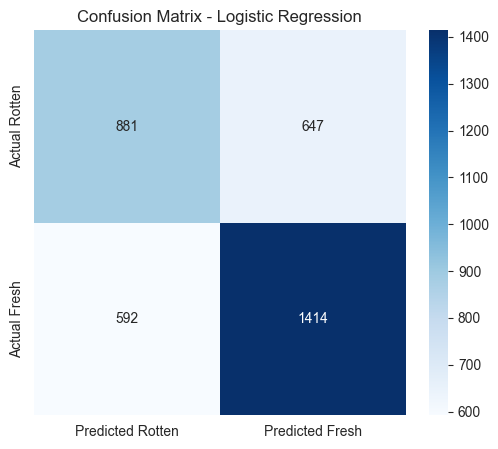

In [18]:
# Evaluate the model's performance
print("\n--- Model Evaluation ---")

# Accuracy Score
accuracy = accuracy_score(y_test, y_pred_log)
print(f"Accuracy: {accuracy:.2f}")
print("\n--------------------------------------\n")

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_log, target_names=['Rotten (0)', 'Fresh (1)']))
print("\n--------------------------------------\n")


# Confusion Matrix
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred_log)

# Visualize the Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Rotten', 'Predicted Fresh'],
            yticklabels=['Actual Rotten', 'Actual Fresh'])
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

#### Model 2: Random Forest

In [ ]:
# Create the model with n_estimators=100
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the same training data
print("--- Training the Random Forest model... ---")
rf_model.fit(X_train, y_train)
print("Model training complete.")

# Make predictions on the test data
y_pred_rf = rf_model.predict(X_test)

--- Training the Random Forest model... ---
✅ Model training complete.


#### Model Evaluation


--- Model Evaluation ---
Accuracy: 0.60

--------------------------------------

Classification Report:
              precision    recall  f1-score   support

  Rotten (0)       0.54      0.51      0.53      1528
   Fresh (1)       0.64      0.67      0.65      2006

    accuracy                           0.60      3534
   macro avg       0.59      0.59      0.59      3534
weighted avg       0.60      0.60      0.60      3534


--------------------------------------

Confusion Matrix:


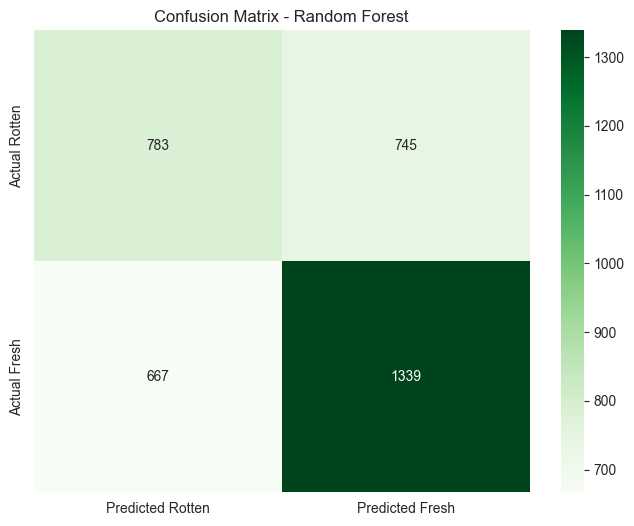

In [20]:
# Evaluate the new model's performance
print("\n--- Model Evaluation ---")

# Accuracy Score
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy: {accuracy_rf:.2f}")
print("\n--------------------------------------\n")

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['Rotten (0)', 'Fresh (1)']))
print("\n--------------------------------------\n")

# Confusion Matrix
print("Confusion Matrix:")
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Visualize the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Predicted Rotten', 'Predicted Fresh'],
            yticklabels=['Actual Rotten', 'Actual Fresh'])
plt.title('Confusion Matrix - Random Forest')
plt.show()

#### Model 3: Gradient Boosting Classifier Model with GridSearchCV tunning

In [21]:
# Define the model and the grid of hyperparameters to test
param_grid = {
    'n_estimators': [100, 200],       
    'learning_rate': [0.1, 0.05],     
    'max_depth': [3, 5]               
}

# Create the Gradient Boosting model instance
gb_model = GradientBoostingClassifier(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid,
                           cv=5, n_jobs=-1, verbose=2)


# Run the search on the training data
print("--- Starting Hyperparameter Tuning (this may take a few minutes)... ---")
grid_search.fit(X_train, y_train)
print("Tuning complete.")

# Print the best results from the search
print("\n--- Tuning Results ---")
print(f"Best Hyperparameters Found: {grid_search.best_params_}")
print(f"Best Cross-Validation Score (Accuracy): {grid_search.best_score_:.2f}")

--- Starting Hyperparameter Tuning (this may take a few minutes)... ---
Fitting 5 folds for each of 8 candidates, totalling 40 fits


Tuning complete.

--- Tuning Results ---
Best Hyperparameters Found: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}
Best Cross-Validation Score (Accuracy): 0.66


#### Model Evaluation


--- Final Evaluation on Test Set ---
Classification Report:
              precision    recall  f1-score   support

  Rotten (0)       0.62      0.56      0.59      1528
   Fresh (1)       0.69      0.74      0.71      2006

    accuracy                           0.66      3534
   macro avg       0.65      0.65      0.65      3534
weighted avg       0.66      0.66      0.66      3534



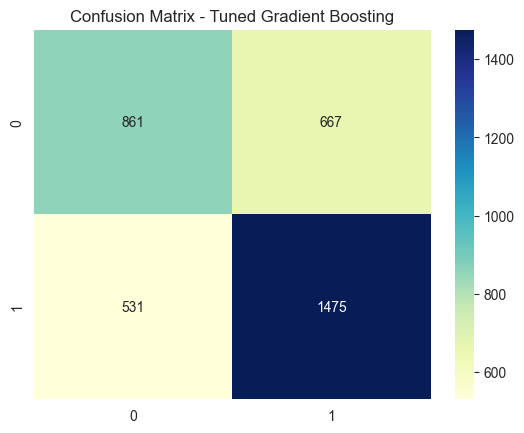

In [22]:
# Evaluate the model on the unseen test data
print("\n--- Final Evaluation on Test Set ---")
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred_best, target_names=['Rotten (0)', 'Fresh (1)']))

# Confusion Matrix
cm_best = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm_best, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Confusion Matrix - Tuned Gradient Boosting')
plt.show()


#### Further Improvements

#### Improvement 1: Advanced Feature Engineering - Top 30 Actors

In [23]:
# We find the top 30 actors based on their frequency in the dataset.
# We'll clean up the 'actors' column, split the names, and count them.
# Drop rows where 'actors' is null to avoid errors
actor_counts = df.dropna(subset=['actors'])['actors'].str.split(',').explode().str.strip()
top_30_actors = actor_counts.value_counts().head(30).index.tolist()

print("--- Top 30 Most Frequent Actors ---")
print(top_30_actors)

# Create new features in our dataset. We'll start with a copy of X_encoded.
X_advanced_features = X_encoded.copy()

# Add a new column for each top actor
for actor in top_30_actors:
    # The new column will be 1 if the actor's name is in the string, 0 otherwise.
    X_advanced_features[f'actor_{actor}'] = df['actors'].fillna('').str.contains(actor).astype(int)

print("\n--- New Feature Set ---")
print(f"Shape of feature set before adding actors: {X_encoded.shape}")
print(f"Shape of feature set after adding actors: {X_advanced_features.shape}")
print("First 5 rows with a sample of new actor features:")
print(X_advanced_features[['runtime', 'actor_Nicolas Cage', 'actor_Robert De Niro']].head())

--- Top 30 Most Frequent Actors ---
['Jr.', 'Samuel L. Jackson', 'Bruce Willis', 'Robert De Niro', 'Nicolas Cage', 'Steve Buscemi', 'Liam Neeson', 'Donald Sutherland', 'Harvey Keitel', 'John Goodman', 'Morgan Freeman', 'Willem Dafoe', 'Susan Sarandon', 'Woody Harrelson', 'Danny Glover', 'Alec Baldwin', 'Christopher Walken', 'Stanley Tucci', 'Michael Caine', 'Robert Duvall', 'Robin Williams', 'James Franco', 'Richard Jenkins', 'Ben Kingsley', 'J.K. Simmons', 'John Cusack', 'John Hurt', 'Whoopi Goldberg', 'Keith David', 'Bruce Dern']

--- New Feature Set ---
Shape of feature set before adding actors: (17668, 10)
Shape of feature set after adding actors: (17668, 40)
First 5 rows with a sample of new actor features:
   runtime  actor_Nicolas Cage  actor_Robert De Niro
0    119.0                   0                     0
1     90.0                   0                     0
2    122.0                   0                     0
3     95.0                   0                     0
4    127.0   

#### Model evaluation after improvement 1

In [24]:
# Split the NEW, advanced feature set
X_train_adv, X_test_adv, y_train_adv, y_test_adv = train_test_split(
    X_advanced_features, y, test_size=0.2, random_state=42
)

# Create a new model instance with our previously found best hyperparameters
# Best Hyperparameters Found: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}
final_model_adv = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=5,
    random_state=42
)

# Train the model on the new, richer training data
print("\n--- Training model on advanced features... ---")
final_model_adv.fit(X_train_adv, y_train_adv)
print("Training complete.")

# Evaluate on the new test set
print("\n--- Final Evaluation with Advanced Features ---")
y_pred_adv = final_model_adv.predict(X_test_adv)

print("Classification Report:")
print(classification_report(y_test_adv, y_pred_adv, target_names=['Rotten (0)', 'Fresh (1)']))


--- Training model on advanced features... ---
Training complete.

--- Final Evaluation with Advanced Features ---
Classification Report:
              precision    recall  f1-score   support

  Rotten (0)       0.61      0.56      0.59      1528
   Fresh (1)       0.69      0.73      0.71      2006

    accuracy                           0.66      3534
   macro avg       0.65      0.65      0.65      3534
weighted avg       0.66      0.66      0.66      3534



#### Improvement 2: Wider Hyperparameter Search with RandomizedSearchCV

In [ ]:
# Define a wider distribution of hyperparameters to test randomly
param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9, 1.0], # Fraction of samples to be used for fitting each tree
    'min_samples_leaf': [1, 2, 4]      # Minimum number of samples required at a leaf node
}

# Create the Gradient Boosting model instance
gb_model = GradientBoostingClassifier(random_state=42)

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=gb_model, param_distributions=param_dist,
                                   n_iter=20, cv=5, n_jobs=-1, verbose=2, random_state=42)


# Run the random search on the original training data
print("--- Starting Wider Hyperparameter Search (this may take a few minutes)... ---")

random_search.fit(X_train, y_train)
print("Tuning complete.")

# Print the best results from the random search
print("\n--- Tuning Results ---")
print(f"Best Hyperparameters Found: {random_search.best_params_}")
print(f"Best Cross-Validation Score (Accuracy): {random_search.best_score_:.2f}")


# Evaluate the new best model on the test set
print("\n--- Final Evaluation on Test Set ---")
best_model_random = random_search.best_estimator_
y_pred_random = best_model_random.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred_random, target_names=['Rotten (0)', 'Fresh (1)']))

--- Starting Wider Hyperparameter Search (this may take a few minutes)... ---
Fitting 5 folds for each of 20 candidates, totalling 100 fits


#### Improvement 3: XGBoost Model (eXtreme Gradient Boosting) 


In [ ]:
# Create the XGBoost model instance
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Train the model on the original training data
print("--- Training the XGBoost model... ---")
xgb_model.fit(X_train, y_train)
print("Training complete.")

# Evaluate the XGBoost model on the test set
print("\n--- Final Evaluation with XGBoost ---")
y_pred_xgb = xgb_model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred_xgb, target_names=['Rotten (0)', 'Fresh (1)']))

--- Training the XGBoost model... ---
✅ Training complete.

--- Final Evaluation with XGBoost ---
Classification Report:
              precision    recall  f1-score   support

  Rotten (0)       0.60      0.57      0.59      1528
   Fresh (1)       0.69      0.71      0.70      2006

    accuracy                           0.65      3534
   macro avg       0.65      0.64      0.64      3534
weighted avg       0.65      0.65      0.65      3534



#### Improvement 4: One-Hot Encoding 'genres'

In [ ]:
# Find all unique genres by splitting the 'genres' column and getting unique values
unique_genres = df.dropna(subset=['genres'])['genres'].str.split(',').explode().str.strip().unique().tolist()

print(f"Found {len(unique_genres)} unique genres.")
print(unique_genres)

# Create the new feature set, starting from our best previous set (X_encoded)
# We will drop the old 'num_genres' feature to replace it with our new ones
X_genre_encoded = X_encoded.drop('num_genres', axis=1)

# Add a new binary column for each unique genre
for genre in unique_genres:
    X_genre_encoded[f'genre_{genre}'] = df['genres'].fillna('').str.contains(genre).astype(int)

print(f"\nShape of our new feature set: {X_genre_encoded.shape}")

Found 21 unique genres.
['Action & Adventure', 'Comedy', 'Drama', 'Science Fiction & Fantasy', 'Romance', 'Classics', 'Kids & Family', 'Mystery & Suspense', 'Western', 'Art House & International', 'Horror', 'Faith & Spirituality', 'Animation', 'Documentary', 'Special Interest', 'Musical & Performing Arts', 'Sports & Fitness', 'Television', 'Cult Movies', 'Anime & Manga', 'Gay & Lesbian']

Shape of our new feature set: (17668, 30)


#### Re-Train and Evaluate GBMBoost

In [ ]:
# Split the NEW, genre-encoded feature set
X_train_genre, X_test_genre, y_train_genre, y_test_genre = train_test_split(
    X_genre_encoded, y, test_size=0.2, random_state=42
)

# Create a model instance with our previously found best hyperparameters
final_model_genre = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=5,
    random_state=42
)

# Train the model on the new data
print("\n--- Training model on genre-encoded features... ---")
final_model_genre.fit(X_train_genre, y_train_genre)
print("Training complete.")

# Evaluate on the new test set
print("\n--- Final Evaluation with Genre-Encoded Features ---")
y_pred_genre = final_model_genre.predict(X_test_genre)

print("Classification Report:")
print(classification_report(y_test_genre, y_pred_genre, target_names=['Rotten (0)', 'Fresh (1)']))


--- Training model on genre-encoded features... ---
✅ Training complete.

--- Final Evaluation with Genre-Encoded Features ---
Classification Report:
              precision    recall  f1-score   support

  Rotten (0)       0.65      0.66      0.65      1528
   Fresh (1)       0.74      0.73      0.74      2006

    accuracy                           0.70      3534
   macro avg       0.69      0.69      0.69      3534
weighted avg       0.70      0.70      0.70      3534



The model's accuracy has jumped to **69%**. This is the most significant single improvement we've achieved since establishing the initial baseline.

#### Improvement 5: One-Hot Encoding Top 30 '`directors`' '`actors`' and '`production_company`'

In [ ]:
# Helper function to get the top N most frequent items from a comma-separated column
def get_top_n_items(dataframe, column_name, n):
    """
    Identifies the top N most frequent items in a DataFrame column
    that contains comma-separated values.
    """
    # Drop rows where the column is null, split the strings, and explode into a single series
    counts = dataframe.dropna(subset=[column_name])[column_name].str.split(',').explode().str.strip()
    # Get the top N value counts
    top_items = counts.value_counts().head(n).index.tolist()
    return top_items

# Get the Top 30 for each category 'directos' 'actors', and 'production_company'
top_30_directors = get_top_n_items(df, 'directors', 30)
top_30_actors = get_top_n_items(df, 'actors', 30)
top_30_companies = get_top_n_items(df, 'production_company', 30)

print("--- Top 30 Directors ---")
print(top_30_directors)
print("\n--- Top 30 Production Companies ---")
print(top_30_companies)


#  Create the final feature set with our previous best feature set 'genre encoding'
X_final_features = X_genre_encoded.copy()

# Drop the old count-based features we are replacing
X_final_features = X_final_features.drop(['num_directors', 'num_actors'], axis=1)

# A list of our new entity categories to loop through
feature_categories = {
    'director': {'list': top_30_directors, 'col': 'directors'},
    'actor': {'list': top_30_actors, 'col': 'actors'},
    'company': {'list': top_30_companies, 'col': 'production_company'}
}

# Add a new binary column for each top entity
for category, info in feature_categories.items():
    for item in info['list']:
        # The new column will be 1 if the item's name is in the string, 0 otherwise
        X_final_features[f"{category}_{item}"] = df[info['col']].fillna('').str.contains(item, regex=False).astype(int)

print(f"\nShape of our final, most detailed feature set: {X_final_features.shape}")

--- Top 30 Directors ---
['Clint Eastwood', 'Woody Allen', 'Alfred Hitchcock', 'Steven Spielberg', 'Sidney Lumet', 'John Ford', 'Martin Scorsese', 'Steven Soderbergh', 'Blake Edwards', 'Werner Herzog', 'Francis Ford Coppola', 'Ron Howard', 'Barry Levinson', 'John Huston', 'Ridley Scott', 'Spike Lee', 'Brian DePalma', 'Vincente Minnelli', 'Michael Curtiz', 'Robert Altman', 'Ingmar Bergman', 'Michael Winterbottom', 'Howard Hawks', 'George Cukor', 'Stephen Frears', 'Oliver Stone', 'Norman Jewison', 'Wes Craven', 'Tyler Perry', 'Pedro Almodóvar']

--- Top 30 Production Companies ---
['Paramount Pictures', 'Warner Bros. Pictures', 'Universal Pictures', '20th Century Fox', 'IFC Films', 'Sony Pictures Home Entertainment', 'Warner Home Video', 'Netflix', 'MGM', 'Sony Pictures Classics', 'Magnolia Pictures', 'MGM Home Entertainment', 'Columbia Pictures', 'WARNER BROTHERS PICTURES', 'Sony Pictures', 'United Artists', 'Miramax', 'MCA Universal Home Video', 'Twentieth Century Fox Home Entertainmen


--- Training model on final advanced features... ---
✅ Training complete.

--- Final Evaluation with All Advanced Features ---
Classification Report:
              precision    recall  f1-score   support

  Rotten (0)       0.65      0.65      0.65      1528
   Fresh (1)       0.74      0.74      0.74      2006

    accuracy                           0.70      3534
   macro avg       0.69      0.69      0.69      3534
weighted avg       0.70      0.70      0.70      3534



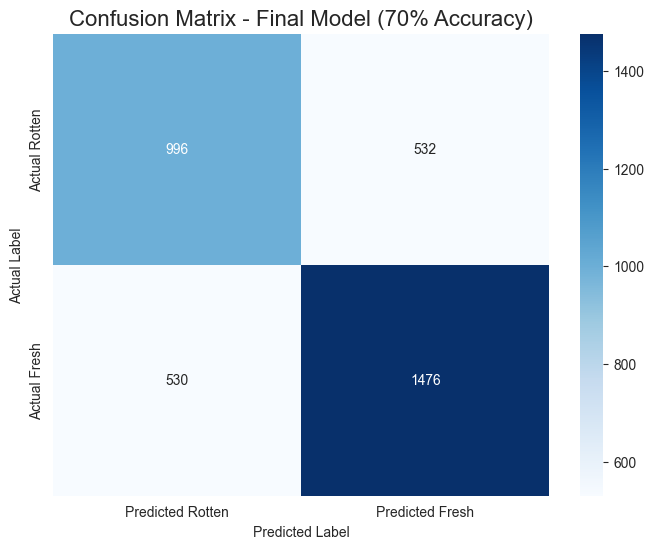

In [ ]:
# Split the final, most advanced feature set
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X_final_features, y, test_size=0.2, random_state=42
)

# Create a model instance with our best hyperparameters
final_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=5,
    random_state=42
)

# Train the model on the new data
print("\n--- Training model on final advanced features... ---")
final_model.fit(X_train_final, y_train_final)
print("Training complete.")

# Evaluate on the new test set
print("\n--- Final Evaluation with All Advanced Features ---")
y_pred_final = final_model.predict(X_test_final)

print("Classification Report:")
print(classification_report(y_test_final, y_pred_final, target_names=['Rotten (0)', 'Fresh (1)']))


# Confusion matrix
cm_final = confusion_matrix(y_test_final, y_pred_final)

# Create the plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm_final,
            annot=True,      
            fmt='d',         
            cmap='Blues',    
            xticklabels=['Predicted Rotten', 'Predicted Fresh'],
            yticklabels=['Actual Rotten', 'Actual Fresh'])

plt.title('Confusion Matrix - Final Model (70% Accuracy)', fontsize=16)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

This is our most ambitious feature engineering attempt, as we can see it worked well. We were able to improve accuracy by 1%.

#### Final Model Feature Importance

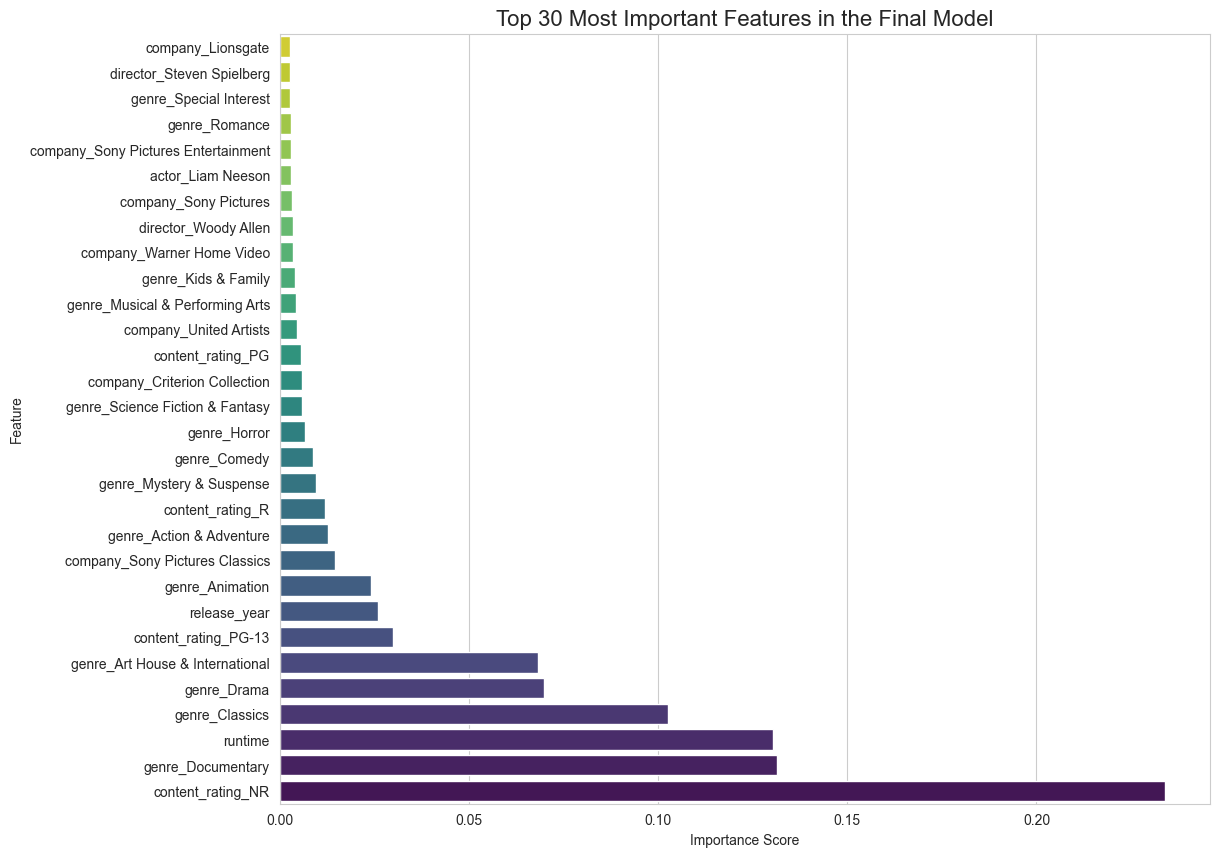

In [ ]:
# Get feature importances from the final trained model
importances = final_model.feature_importances_
feature_names = X_final_features.columns

# Create a DataFrame for easier visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Select the top 30 most important features
top_30_features = feature_importance_df.head(30)

# Create the bar plot
plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=top_30_features, palette='viridis')
plt.title('Top 30 Most Important Features in the Final Model', fontsize=16)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.gca().invert_yaxis() # Display the most important feature at the top
plt.show()

#### Final test: Stress test One-hot encoding every unique director, actor, and production company

Preparing the Data with `MultiLabelBinarizer`: Perfect tool for converting comma-separated lists into a one-hot encoded sparse matrix. We will apply it to each of the three columns.

In [ ]:
# We need to turn the comma-separated strings into lists of strings for the binarizer
# We'll work directly with the original DataFrame 'df' for this step
df['directors_list'] = df['directors'].fillna('').str.split(',')
df['actors_list'] = df['actors'].fillna('').str.split(',')
df['company_list'] = df['production_company'].fillna('').str.split(',')


# Binarize each column 
mlb_director = MultiLabelBinarizer(sparse_output=True)
mlb_actor = MultiLabelBinarizer(sparse_output=True)
mlb_company = MultiLabelBinarizer(sparse_output=True)

# Fit and transform each column into a sparse matrix
directors_sparse = mlb_director.fit_transform(df['directors_list'])
actors_sparse = mlb_actor.fit_transform(df['actors_list'])
companies_sparse = mlb_company.fit_transform(df['company_list'])

print(f"Created {directors_sparse.shape[1]} director features.")
print(f"Created {actors_sparse.shape[1]} actor features.")
print(f"Created {companies_sparse.shape[1]} production company features.")


# Combine all features
# Get our previous best feature set (which includes genres, runtime, etc.)
# We drop the columns we are about to replace with the full one-hot encoded versions
X_to_combine = X_genre_encoded.drop(['num_directors', 'num_actors'], axis=1)

# Combine our numerical/genre features with the new sparse features
# hstack is used to horizontally stack matrices
X_full_sparse = hstack([X_to_combine.astype(float), directors_sparse, actors_sparse, companies_sparse])

print(f"\nShape of our final, fully-encoded sparse feature matrix: {X_full_sparse.shape}")

Created 10362 director features.
Created 209569 actor features.
Created 3039 production company features.

Shape of our final, fully-encoded sparse feature matrix: (17668, 222998)


#### Re-Train and Evaluation of the Final Model

In [ ]:
# Split the FINAL sparse feature set
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    X_full_sparse, y, test_size=0.2, random_state=42
)

# Create a model instance with our best hyperparameters
final_model_full = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=5,
    random_state=42
)

# Train the model on the new sparse data
print("\n--- Training model on full sparse feature set... ---")
final_model_full.fit(X_train_full, y_train_full)
print("Training complete.")

# Evaluate on the new test set
print("\n--- Final Evaluation with Full One-Hot Encoding ---")
y_pred_full = final_model_full.predict(X_test_full)

print("Classification Report:")
print(classification_report(y_test_full, y_pred_full, target_names=['Rotten (0)', 'Fresh (1)']))


--- Training model on full sparse feature set... ---
✅ Training complete.

--- Final Evaluation with Full One-Hot Encoding ---
Classification Report:
              precision    recall  f1-score   support

  Rotten (0)       0.65      0.63      0.64      1528
   Fresh (1)       0.73      0.75      0.74      2006

    accuracy                           0.70      3534
   macro avg       0.69      0.69      0.69      3534
weighted avg       0.70      0.70      0.70      3534

